In [ ]:
import cv2
import numpy as np
import numpy
import  matplotlib.pyplot as plt
import time
import math
def show(img):
  plt.imshow(img, cmap = "gray")

def showC(img):
  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(rgb, cmap = "gray")

def timer(func):
  def wrapper( *args, **kwargs):
    t0 = time.time()
    result = func(*args, **kwargs)
    t1 =time.time()
    print(f'Function {func.__name__} took: {round((t1-t0)*1000, 6)} (ms)')
    return result
  return wrapper

In [ ]:
!pip install numba --upgrade

In [ ]:
import numba
from numba import jit, cuda

## CUDA

(3048, 4024)
2


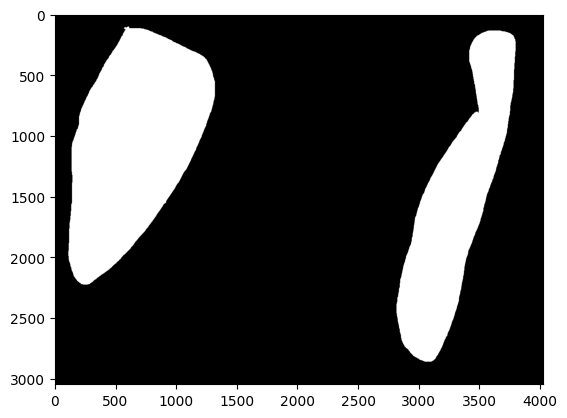

In [ ]:
img = cv2.imread("shape12_1.png")
gray  = cv2.imread("shape12_1.png",0)
show(gray)
print(gray.shape)

# Threshold and Find contours
_, threshold =cv2.threshold( gray, 200, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

In [ ]:
# Tinh Grid Size, Blocks
contour1 = contours[0].astype(np.float32)
contour2 = contours[1].astype(np.float32)

In [ ]:
print(f'Number point contour1: {len(contour1)}')
print(f'Number point contour2: {len(contour2)}')

Number point contour1: 5847
Number point contour2: 4839


## Scalar

In [ ]:
@timer
def min_contours_distance(contour1, contour2):

    number_point_contour1 = len(contour1)
    number_point_contour2 = len(contour2)

    point1_min_x = 0
    point1_min_y = 0

    point2_min_x = 0
    point2_min_y = 0

    min_distance = 1e8

    for i in range(number_point_contour1):
        for j in range(number_point_contour2):

            point1  = contour1[i]
            point2  = contour2[j]

            x1, y1 = point1[0], point1[1]
            x2, y2 = point2[0], point2[1]

            dis = math.sqrt((x1-x2)**2 + (y1-y2)**2)

            if dis < min_distance :
                min_distance = dis

                point1_min_x, point1_min_y = point1[0], point1[1]
                point2_min_x, point2_min_y = point2[0], point2[1]

    # print((point1_min_x, point1_min_y))
    # print((point2_min_x, point2_min_y))
    return min_distance , (point1_min_x, point1_min_y),(point2_min_x, point2_min_y)

In [ ]:
cnt1 = np.squeeze(contours[0], axis = 1)
cnt2 = np.squeeze(contours[1], axis = 1)

min_distance , (point1_min_x, point1_min_y),(point2_min_x, point2_min_y) = min_contours_distance(cnt1, cnt2 )

Function min_contours_distance took: 137328.351259 (ms)


In [ ]:
print(f'Mindistance: {min_distance}')
print(f'Point1: {(point1_min_x, point1_min_y)}')
print(f'Point2: {(point2_min_x, point2_min_y)}')

Mindistance: 1874.2219719126122
Point1: (3013, 1541)
Point2: (1245, 919)


## Numpy

In [ ]:
@timer
def min_contours_distance_numpy(contour1 :np.array , contour2 :np.array) -> (numpy.array,numpy.array) :

    minDistace = np.empty(len(contour1), dtype = np.float32)
    pointIndex = np.empty(len(contour1), dtype = np.float32)

    x_2 = contour2[: ,0, 0]
    y_2 = contour2[: ,0, 1]

    for i in range(len(contour1)):
        x = contour1[i,0,0]
        y = contour1[i,0,1]

        diff_x = x  - x_2
        diff_y = y  - y_2

        dis = diff_x*diff_x + diff_y* diff_y
        minDistace[i] = np.sqrt(np.amin(dis)) # Tim maximum distance -> np.amax()
        pointIndex[i] = np.argmin(dis)        # Tim maximum distance -> np.argmax()

    return minDistace,pointIndex

In [ ]:
minDistace,pointIndex = min_contours_distance_numpy(contour1, contour2)
print(f'Mindistance: {min_distance}')
print(f'Args point contour1: {np.argmin(minDistace)}')
print(f'Args point contour2: {pointIndex[np.argmin(minDistace)]}')

Function min_contours_distance_numpy took: 146.272182 (ms)
Mindistance: 1874.2219719126122
Args point contour1: 1520
Args point contour2: 3624.0


In [ ]:
contour1[1520], contour2[3624]

(array([[3013., 1541.]], dtype=float32),
 array([[1245.,  919.]], dtype=float32))

## Numba

In [ ]:
@timer
@numba.jit(parallel  = True)
def min_contours_distance_numba(contour1 :np.array , contour2 :np.array) -> (numpy.array,numpy.array) :

    minDistace = np.empty(len(contour1), dtype = np.float32)
    pointIndex = np.empty(len(contour1), dtype = np.float32)

    x_2 = contour2[: ,0, 0]
    y_2 = contour2[: ,0, 1]

    for i in numba.prange(len(contour1)):
        x = contour1[i,0,0]
        y = contour1[i,0,1]

        diff_x = x  - x_2
        diff_y = y  - y_2

        dis = diff_x*diff_x + diff_y* diff_y
        minDistace[i] = np.sqrt(np.amin(dis)) # Tim maximum distance -> np.amax()
        pointIndex[i] = np.argmin(dis)        # Tim maximum distance -> np.argmax()

    return minDistace,pointIndex

<ipython-input-31-1e0a6dc55502>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel  = True)


In [ ]:
minDistace,pointIndex = min_contours_distance_numba(contour1, contour2)
print(f'Min Distance: {min_distance}')
print(f'Args point contour1: {np.argmin(minDistace)}')
print(f'Args point contour2: {pointIndex[np.argmin(minDistace)]}')

Function min_contours_distance_numba took: 79.8738 (ms)
Min Distance: 1874.2219719126122
Args point contour1: 1520
Args point contour2: 3624.0


## CUDA

In [ ]:
@cuda.jit()
def min_contours_distance_cuda(contour1, contour2, minDistance, pointIndex):

  i = cuda.grid(1) # i <=> threadIdx trong moi blocks

  x_1 = contour1[i ,0, 0]
  y_1 = contour1[i ,0, 1]

  if i < len(contour1):
    min_dist = 10e8
    min_index = -1

    for j in range(len(contour2)):

      x_2 = contour2[j ,0, 0]
      y_2 = contour2[j ,0, 1]

      diff_x = x_1 - x_2
      diff_y = y_1 - y_2

      distance = math.sqrt(diff_x * diff_x + diff_y * diff_y)

      if distance < min_dist:
        min_dist = distance
        min_index = j

    minDistance[i] = min_dist
    pointIndex[i] = min_index

In [ ]:
len(contour1), len(contour2)

(5847, 4839)

In [ ]:
# Tinh Grid Size, Blocks
contour1 = contours[0].astype(np.float32)
contour2 = contours[1].astype(np.float32)

minDistance  =  np.empty(len(contour1), dtype = np.float32)
pointIndex   = np.empty(len(contour1), dtype = np.int16)

block_size = 16
grid_size = (len(contour1) + block_size  ) // block_size

t0  = time.time()
min_contours_distance_cuda[grid_size,block_size](contour1, contour2,minDistance, pointIndex )
t1 = time.time()

print(f"Time Process: {(t1-t0)*1000} (ms)")
print(f'Min Distance: {np.min(minDistance)}')
print(f'Args point contour1: {np.argmin(minDistance)}')
print(f'Args point contour2: {pointIndex[np.argmin(minDistace)]}')

Time Process: 7.955074310302734 (ms)
Min Distance: 1874.221923828125
Args point contour1: 1520
Args point contour2: 3624


## Polar

In [ ]:
img = cv2.imread("lens.png")
gray = cv2.imread("lens.png",0)

new_dim = (gray.shape[1]* 5 , gray.shape[0]*5)

gray = cv2.resize(gray, (new_dim),interpolation = cv2.INTER_AREA)

print(gray.shape)

(3175, 4760)


## Polar Numpy

In [ ]:
@timer
def polar_transfrom(img):

    height, width = img.shape[0] , img.shape[1]

    max_r = int(math.sqrt((height/2)**2 + (width/2)**2)) + 20

    center_x = width // 2
    center_y = height // 2
    theta = 360
    polar_space = np.zeros((max_r, theta), dtype=np.int16)

    for the in range(theta):
        for r in range(max_r*2):

            x = int(center_x +  r * np.cos(np.radians(the)))
            y = int(center_y +  r * np.sin(np.radians(the)))

            if 0 <= x <width and 0 <= y < height:

                polar_space[r,the] = img[y, x]


    return polar_space.astype(np.uint8)

def polar_to_2d(r, theta,center):
    center_x = center[0]
    center_y = center[1]

    x = int(center_x +  r * np.cos(np.radians(theta)))
    y = int(center_y +  r * np.sin(np.radians(theta)))

    return x, y

Function polar_transfrom took: 10934.823513 (ms)


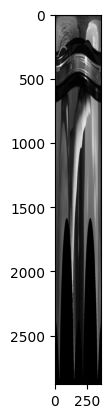

In [ ]:
polar  = polar_transfrom(gray)
show(polar)

## Numba

In [ ]:
@timer
@numba.jit(parallel = True)
def polar_transfrom(img):

    height, width = img.shape[0] , img.shape[1]

    max_r = int(math.sqrt((height/2)**2 + (width/2)**2)) + 20
    print(f'max r: {max_r}')

    center_x = width // 2
    center_y = height // 2
    theta = 360
    polar_space = np.zeros((max_r, theta), dtype=np.int16)

    for the in numba.prange(theta):
        for r in numba.prange(max_r*2):

          x = int(center_x +  r * np.cos(np.radians(the)))
          y = int(center_y +  r * np.sin(np.radians(the)))

          if 0 <= x <width and 0 <= y < height:

            polar_space[r,the] = img[y, x]


    return polar_space.astype(np.uint8)

<ipython-input-100-344258430fc8>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel = True)


max r: 2880
Function polar_transfrom took: 9.353399 (ms)


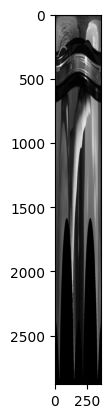

In [ ]:
polar  = polar_transfrom(gray)
show(polar)

## CUDA

In [ ]:
@cuda.jit()
def polar_transfrom_cuda(img ,polar_space):# matrix2D (allocated on GPU)
  height, width = img.shape[0] , img.shape[1]

  max_r = int(math.sqrt((height/2)**2 + (width/2)**2)) + 20

  center_x = width // 2
  center_y = height // 2

  theta_i = cuda.grid(1)

  if theta_i < polar_space.shape[1]:
    for r in range(max_r*2):

      x = int(center_x +  r * np.cos(np.radians(theta_i)))
      y = int(center_y +  r * np.sin(np.radians(theta_i)))

      if 0 <= x <width and 0 <= y < height:

        polar_space[r,theta_i] = img[y, x]

In [ ]:
img.shape

(635, 952, 3)

Time Process: 0.5028247833251953 (ms)


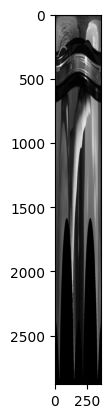

In [ ]:
height, width = gray.shape[0] , gray.shape[1]
max_r = int(math.sqrt((height /2 ) **2 + (width /2)**2 )) +  20
theta = 360

# np.zeros() -> CPU
polar_space_gpu = cuda.device_array((max_r,theta ), dtype = np.uint8)

# img on CPU
gray_device = cuda.to_device(gray)

# grid size, blocks
blocks_size =  (16, 16)

grid_size = ((max_r  + blocks_size[0] ) // blocks_size[0] , (theta  + blocks_size[1] ) // blocks_size[1])


t0  = time.time()
polar_transfrom_cuda[grid_size,blocks_size ](gray_device,polar_space_gpu)
t1 = time.time()


polar_space_cpu = polar_space_gpu.copy_to_host()
show(polar_space_cpu)
print(f"Time Process: {(t1-t0)*1000} (ms)")